# Artificial Intelligence: Homework 2 - Machine Learning

Alexandru Sima (332CA)


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

%matplotlib inline

## Air pollution


In [78]:
data = pd.read_csv("datasets/air_pollution_full.csv")

##### Split data by type


In [79]:
def split_data(
    data: pd.DataFrame,
    numeric_columns: list[str],
    categorical_columns: list[str],
    label_column: str,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    numeric_attrs = [x for x in numeric_columns if x in data.columns]
    categorical_attrs = [x for x in categorical_columns if x in data.columns]

    numeric_attrs = data[numeric_attrs]
    categorical_attrs = data[categorical_attrs]
    labels = data[label_column]

    return numeric_attrs, categorical_attrs, labels

In [80]:
numeric_columns = [
    "AQI_Value",
    "CO_Value",
    "Ozone_Value",
    "NO2_Value",
    "PM25_Value",
    "VOCs",
    "SO2",
]
categorical_columns = [
    "Country",
    "City",
    "CO_Category",
    "Ozone_Category",
    "NO2_Category",
    "PM25_Category",
    "Emissions",
]
label_column = "AQI_Category"

In [81]:
num_data, cat_data, labels = split_data(
    data, numeric_columns, categorical_columns, label_column
)

### Exploratory data analysis


In [82]:
def print_numerical_info(data: pd.DataFrame):
    data.boxplot()
    print(data.describe())

          AQI_Value      CO_Value   Ozone_Value     NO2_Value    PM25_Value  \
count  23463.000000  23463.000000  21117.000000  23463.000000  23463.000000   
mean      72.010868      1.368367     35.239665     43.084153     68.519755   
std       56.055220      1.832064     28.149280    196.079179     54.796443   
min        6.000000      0.000000      0.000000      0.000000      0.000000   
25%       39.000000      1.000000     21.000000      0.000000     35.000000   
50%       55.000000      1.000000     31.000000      1.000000     54.000000   
75%       79.000000      1.000000     40.000000      4.000000     79.000000   
max      500.000000    133.000000    222.000000   1003.063334    500.000000   

               VOCs           SO2  
count  23463.000000  23463.000000  
mean     185.053110      4.447841  
std      140.486759      5.953601  
min       12.415670    -18.528019  
25%      103.267345      0.735052  
50%      142.972272      4.286825  
75%      204.227896      7.916001  


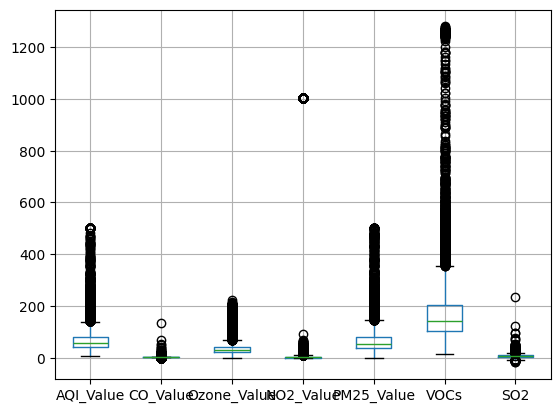

In [83]:
print_numerical_info(num_data)

Class distribution


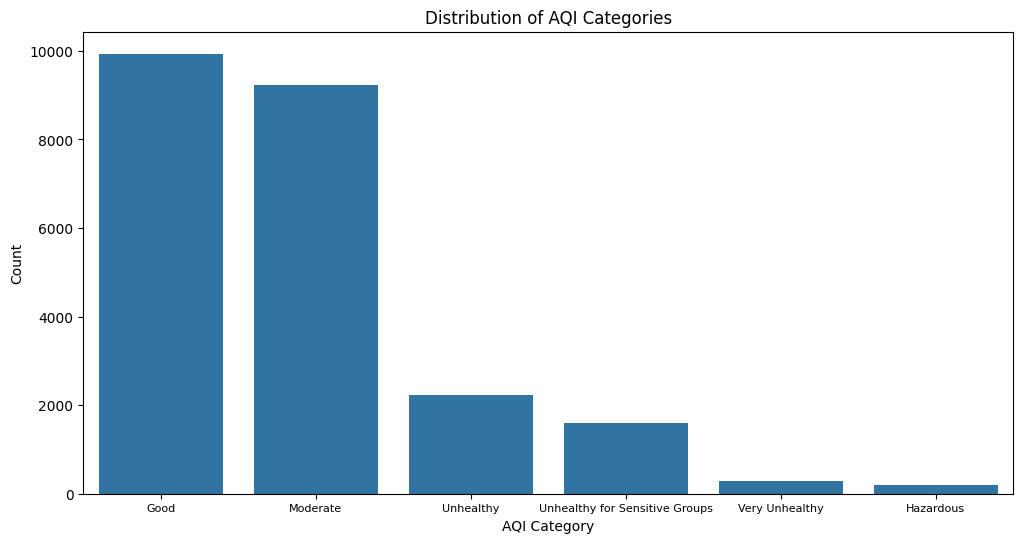

In [84]:
plt.figure(figsize=(12, 6))

sns.barplot(labels.value_counts())
plt.title("Distribution of AQI Categories")
plt.xticks(fontsize=8)
plt.xlabel("AQI Category")
plt.ylabel("Count")
plt.show()

#### Atribute corellation


In [85]:
def get_highly_correlated_features(
    title: str,
    data: pd.DataFrame,
    threshold: float = 0.8,
    annot: bool = True,
    show_correlations: bool = False,
) -> list[str]:
    correlation_mat = data.corr()
    correlated_features = set()

    correlation = num_data.corr()
    sns.heatmap(correlation, annot=annot, fmt=".2f", cmap="coolwarm")
    plt.title(title, pad=20)
    plt.show()

    for i, row in enumerate(correlation_mat.columns):
        for j, col in enumerate(correlation_mat.columns):
            if i <= j or col in correlated_features:
                continue

            corr = correlation_mat.loc[row, col]
            if abs(corr) < threshold or not show_correlations:
                continue

            print(f"Correlation between {row} and {col}: {corr:.2f}")
            correlated_features.add(col)

            correlated_data = data[[row, col]].copy()
            correlated_data.sort_values(by=row, inplace=True)
            correlated_data.reset_index(drop=True, inplace=True)

            sns.lmplot(data=correlated_data, x=row, y=col, ci=None)
            plt.xlabel(row)
            plt.ylabel(col)
            plt.title(f"Correlation between {row} and {col}")
            plt.show()

    return list(correlated_features)

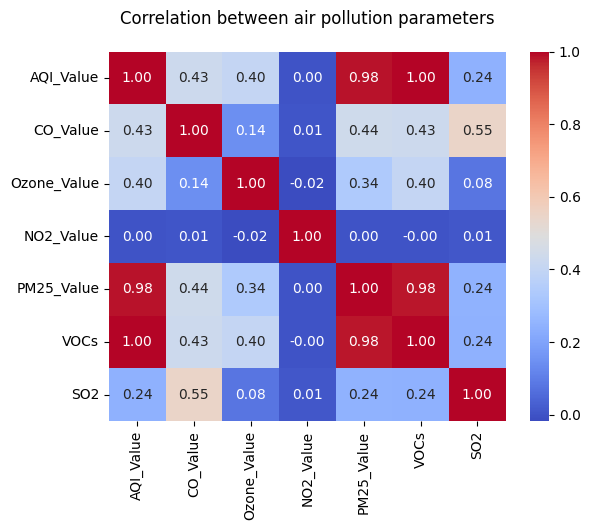

In [86]:
correlated_num_features = get_highly_correlated_features(
    "Correlation between air pollution parameters", num_data
)

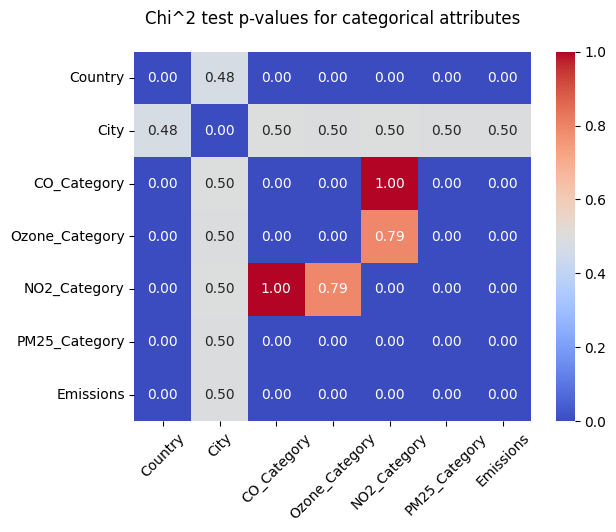

In [87]:
def correlated_cat_features(threshold: int = 0.2, annot: bool = True) -> list[str]:
    pvalues = np.zeros((len(cat_data.columns), len(cat_data.columns)))

    for i, row in enumerate(cat_data.columns):
        for j, col in enumerate(cat_data.columns):
            if row == col:
                continue

            observed = pd.crosstab(cat_data[row], cat_data[col])

            statistic = sp.stats.chi2_contingency(observed)
            pvalues[i, j] = statistic.pvalue

    sns.heatmap(pvalues, annot=annot, fmt=".2f", cmap="coolwarm")
    plt.xticks(
        ticks=0.5 + np.arange(len(cat_data.columns)),
        labels=cat_data.columns,
        rotation=45,
    )
    plt.yticks(
        ticks=0.5 + np.arange(len(cat_data.columns)),
        labels=cat_data.columns,
        rotation=0,
    )
    plt.title("Chi^2 test p-values for categorical attributes", pad=20)
    plt.show()


correlated_cat_features()

### Preprocessing


#### Extreme values


In [88]:
class OutlierRemover:
    def __init__(self, q1: float = 0.25, q3: float = 0.75):
        self.q1 = q1
        self.q3 = q3

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        for col in X.columns:
            values = X[col]

            q1 = values.quantile(self.q1)
            q3 = values.quantile(self.q3)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            X.loc[(values < lower_bound) | (values > upper_bound), col] = np.nan
        return X

#### Redundant attributes


We can see from the correlation matrix that columns _0_, _4_ and _5_ are very
strongly correlated (correlation index is **$\approx$ 1**), so, we can remove,
for example, columns _4_ and _5_.


In [89]:
redundant_features = ["City"]  # unique values, not useful
redundant_features += correlated_num_features

numeric_columns = [x for x in numeric_columns if x not in redundant_features]
categorical_columns = [x for x in categorical_columns if x not in redundant_features]

### Preprocessing pipeline


In [90]:
numeric_pipeline = sk.pipeline.Pipeline(
    steps=[
        ("remover", OutlierRemover()),
        ("imputer", sk.impute.SimpleImputer()),
        ("scaler", sk.preprocessing.RobustScaler()),
    ]
)

categorical_pipeline = sk.pipeline.Pipeline(
    steps=[
        ("imputer", sk.impute.SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            sk.preprocessing.OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=-1
            ),
        ),
    ]
)

In [91]:
preprocessor = sk.compose.ColumnTransformer(
    transformers=[
        ("extra", "drop", redundant_features),
        ("numeric", numeric_pipeline, numeric_columns),
        ("categorical", categorical_pipeline, categorical_columns),
    ]
)

label_encoder = sk.preprocessing.LabelEncoder()

### Prediction


#### Loading and preprocessing data


In [92]:
train_data = pd.read_csv("datasets/air_pollution_train.csv")
test_data = pd.read_csv("datasets/air_pollution_test.csv")

In [93]:
train_labels = label_encoder.fit_transform(train_data[label_column])
train_data = preprocessor.fit_transform(train_data)

test_labels = label_encoder.transform(test_data[label_column])
test_data = preprocessor.transform(test_data)

#### Classifiers


In [94]:
def run_classifier(
    name: str, classifier, test_data: pd.DataFrame, test_labels: pd.Series
) -> tuple[str, float, float, float, float]:
    predicted_labels = classifier.predict(test_data)

    sk.metrics.ConfusionMatrixDisplay.from_predictions(
        test_labels,
        predicted_labels,
    )
    plt.show()

    accuracy = classifier.score(test_data, test_labels)
    precison = sk.metrics.precision_score(
        test_labels, predicted_labels, average="macro", zero_division=0
    )
    recall = sk.metrics.recall_score(test_labels, predicted_labels, average="macro")
    f1 = sk.metrics.f1_score(test_labels, predicted_labels, average="macro")

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precison:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1: {f1:.2f}")

    return name, accuracy, precison, recall, f1

In [95]:
scores = []

##### Decision Tree


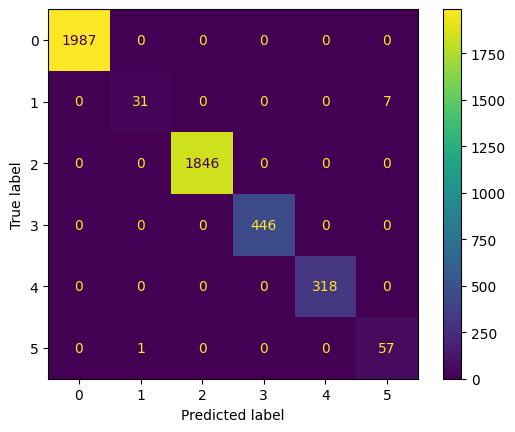

Accuracy: 1.00
Precision: 0.98
Recall: 0.97
F1: 0.97


In [96]:
classifier = sk.tree.DecisionTreeClassifier()
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Decision Tree",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

##### Random forest


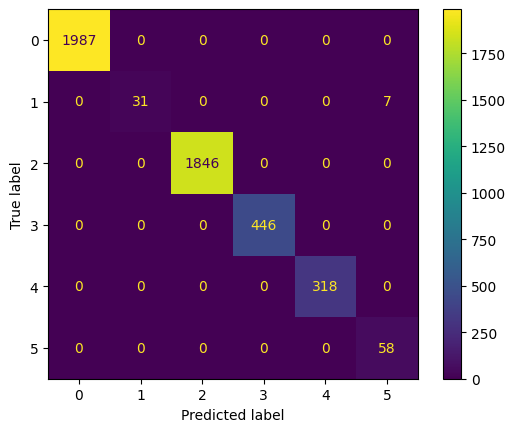

Accuracy: 1.00
Precision: 0.98
Recall: 0.97
F1: 0.97


In [97]:
classifier = sk.ensemble.RandomForestClassifier()
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Random Forest",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

##### Logistic regression


In [98]:
class MultiClassLogisticRegression:
    class LogisticRegression:
        @staticmethod
        def sigmoid(
            x: np.ndarray,
        ) -> np.ndarray:  # multe probleme daca nu sunt scalate datele
            return 1 / (1 + np.exp(-x))

        def __init__(self, max_iter: int, lr: float, l2: float):
            self.max_iter = max_iter
            self.lr = lr
            self.l2 = l2

        def predict(self, X: np.ndarray) -> np.ndarray:
            return self.sigmoid(X @ self.w)

        def fit(self, X: np.ndarray, t: np.ndarray):
            n, d = X.shape
            self.w = np.random.randn(d)

            for _ in range(self.max_iter):
                y = self.predict(X)
                grad = (1 / n) * (X.T @ (y - t))
                self.w -= self.lr * grad + self.l2 * np.abs(self.w)

        def accuracy(self, X, t):
            y = self.predict(X)
            n, _ = y.shape

            return (np.sum(y[t == 1] >= 0.5) + np.sum(y[t == 0] < 0.5)) / n

    def __init__(self, max_iter: int = 1000, learning_rate: float = 0.01, l2: float = 0.0):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.l2 = l2

    @staticmethod
    def _add_bias(X: np.ndarray) -> np.ndarray:
        bias = np.ones((X.shape[0], 1))
        return np.concatenate((bias, X), axis=1)

    def fit(self, X: np.ndarray, labels: np.ndarray):
        self.predictors = []
        X = self._add_bias(X)

        for target in np.unique(labels):
            target_labels = labels == target

            predictor = self.LogisticRegression(self.max_iter, self.learning_rate, self.l2)
            predictor.fit(X, target_labels)

            self.predictors.append(predictor)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = self._add_bias(X)

        y = self.predictors[0].predict(X)
        classes = np.zeros_like(y, dtype=int)

        for i, predictor in enumerate(self.predictors[1:]):
            yy = predictor.predict(X)
            improv = yy > y

            y[improv] = yy[improv]
            classes[improv] = i + 1

        return classes

    def score(self, X: np.ndarray, labels: pd.Series) -> float:
        Y = self.predict(X)
        return sk.metrics.accuracy_score(labels, Y)

/tmp/ipykernel_64831/2550238166.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


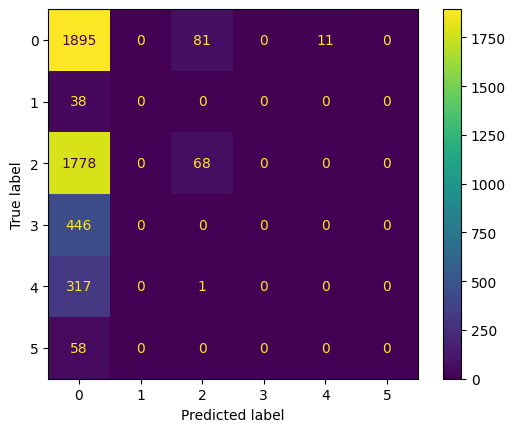

Accuracy: 0.42
Precision: 0.15
Recall: 0.17
F1: 0.11


/tmp/ipykernel_64831/2550238166.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [99]:
classifier = MultiClassLogisticRegression(max_iter=10000, learning_rate=0.001, l2=0.01)
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Logistic Regression",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

##### Multi-layered perceptron


In [ ]:
classifier = sk.neural_network.MLPClassifier(hidden_layer_sizes=[64, 64])
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Neural Network",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

#### Classifier comparison


In [ ]:
def compare_classifiers(scores: list[tuple[str, float, float, float, float]]):
    columns = ["Name", "Accuracy", "Precision", "Recall", "F1"]
    scores = pd.DataFrame(scores, columns=columns)

    for col in columns[1:]:
        sns.barplot(
            data=scores,
            x=columns[0],
            y=col,
        )

        plt.xlabel("Classifier")
        plt.ylabel(f"{col} score")
        plt.title(f"{col} score for different classifiers")
        plt.show()

In [ ]:
compare_classifiers(scores)

## News popularity


In [59]:
data = pd.read_csv("datasets/news_popularity_full.csv")

In [60]:
numeric_columns = [
    " days_since_published",
    " title_word_count",
    " content_word_count",
    " unique_word_ratio",
    " non_stop_word_ratio",
    " unique_non_stop_ratio",
    " external_links",
    " internal_links",
    " image_count",
    " video_count",
    " avg_word_length",
    " keyword_count",
    " keyword_worst_min_shares",
    " keyword_worst_max_shares",
    " keyword_worst_avg_shares",
    " keyword_best_min_shares",
    " keyword_best_max_shares",
    " keyword_best_avg_shares",
    " keyword_avg_min_shares",
    " keyword_avg_max_shares",
    " keyword_avg_avg_shares",
    " ref_min_shares",
    " ref_max_shares",
    " ref_avg_shares",
    " topic_0_relevance",
    " topic_1_relevance",
    " topic_2_relevance",
    " topic_3_relevance",
    " topic_4_relevance",
    " content_subjectivity",
    " content_sentiment",
    " positive_word_rate",
    " negative_word_rate",
    " non_neutral_positive_rate",
    " non_neutral_negative_rate",
    " avg_positive_sentiment",
    " min_positive_sentiment",
    " max_positive_sentiment",
    " avg_negative_sentiment",
    " min_negative_sentiment",
    " max_negative_sentiment",
    " title_subjectivity",
    " title_sentiment",
    " title_subjectivity_magnitude",
    " title_sentiment_magnitude",
    " engagement_ratio",
    " content_density",
]
categorical_columns = [
    "url",
    " channel_lifestyle",
    " channel_entertainment",
    " channel_business",
    " channel_social_media",
    " channel_tech",
    " channel_world",
    " day_monday",
    " day_tuesday",
    " day_wednesday",
    " day_thursday",
    " day_friday",
    " day_saturday",
    " day_sunday",
    " is_weekend",
    " publication_period",
]
label_column = "popularity_category"

In [61]:
num_data, cat_data, labels = split_data(
    data, numeric_columns, categorical_columns, label_column
)

### Exploratory data analysis


       days_since_published  title_word_count  content_word_count  \
count          39644.000000      39644.000000        39644.000000   
mean             354.530471         10.398749          546.514731   
std              214.163767          2.114037          471.107508   
min                8.000000          2.000000            0.000000   
25%              164.000000          9.000000          246.000000   
50%              339.000000         10.000000          409.000000   
75%              542.000000         12.000000          716.000000   
max              731.000000         23.000000         8474.000000   

       unique_word_ratio  non_stop_word_ratio  unique_non_stop_ratio  \
count       39644.000000         39644.000000           39644.000000   
mean            0.548216             0.996469               0.689175   
std             3.520708             5.231231               3.264816   
min             0.000000             0.000000               0.000000   
25%             0.

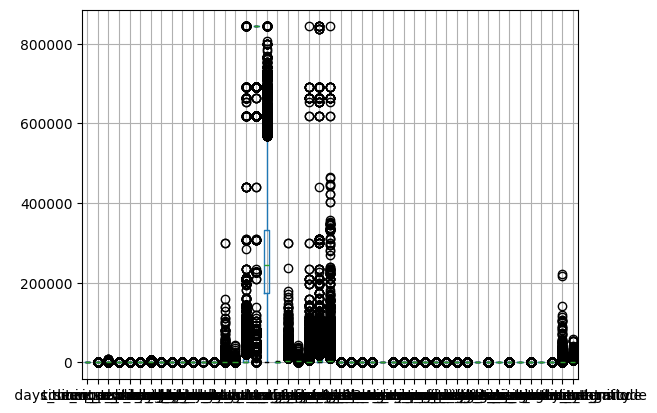

In [62]:
print_numerical_info(num_data)

#### Atribute corellation


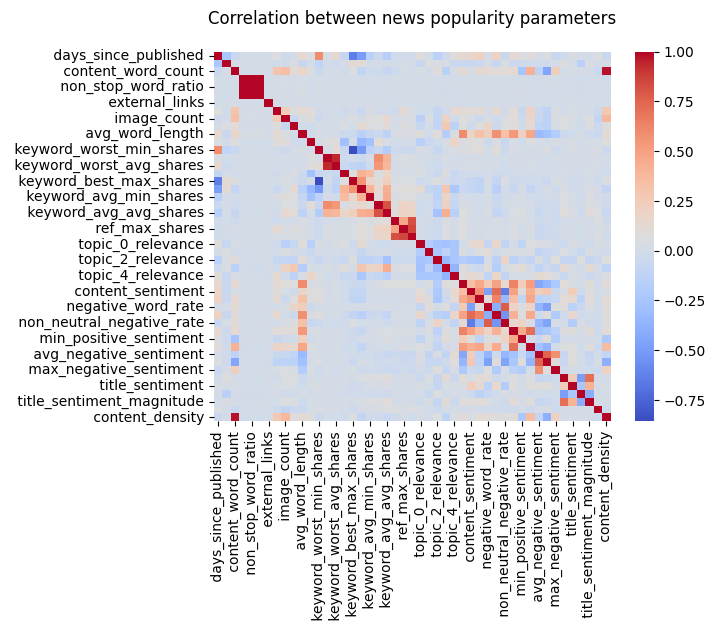

In [63]:
correlated_num_features = get_highly_correlated_features(
    "Correlation between news popularity parameters", num_data, annot=False
)

### Preprocessing


In [64]:
redundant_features = ["url"]  # unique values, not useful
redundant_features += correlated_num_features

numeric_columns = [x for x in numeric_columns if x not in redundant_features]
categorical_columns = [x for x in categorical_columns if x not in redundant_features]

In [65]:
numeric_pipeline = sk.pipeline.Pipeline(
    steps=[
        ("remover", OutlierRemover()),
        ("imputer", sk.impute.SimpleImputer()),
        ("scaler", sk.preprocessing.RobustScaler()),
    ]
)

categorical_pipeline = sk.pipeline.Pipeline(
    steps=[
        ("imputer", sk.impute.SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            sk.preprocessing.OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=-1
            ),
        ),
    ]
)

In [66]:
preprocessor = sk.compose.ColumnTransformer(
    transformers=[
        ("extra", "drop", redundant_features),
        ("numeric", numeric_pipeline, numeric_columns),
        ("categorical", categorical_pipeline, categorical_columns),
    ]
)

label_encoder = sk.preprocessing.LabelEncoder()

#### Loading and preprocessing data


In [67]:
train_data = pd.read_csv("datasets/news_popularity_train.csv")
test_data = pd.read_csv("datasets/news_popularity_test.csv")

In [68]:
train_labels = label_encoder.fit_transform(train_data[label_column])
train_data = preprocessor.fit_transform(train_data)

test_labels = label_encoder.transform(test_data[label_column])
test_data = preprocessor.transform(test_data)

### Training and prediction


In [69]:
scores = []

#### Decision Tree


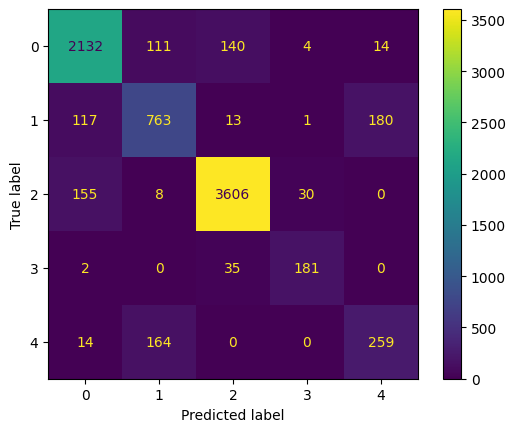

Accuracy: 0.88
Precision: 0.79
Recall: 0.79
F1: 0.79


In [70]:
classifier = sk.tree.DecisionTreeClassifier()
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Decision Tree",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

#### Random forest


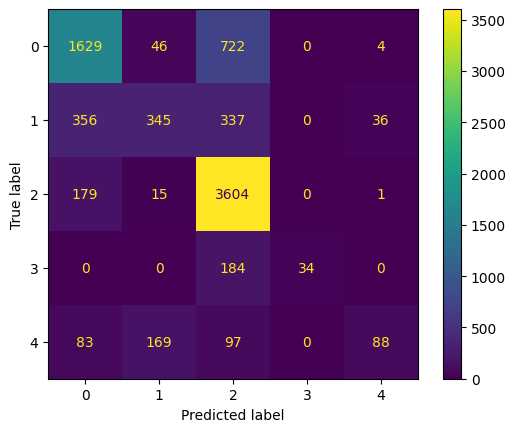

Accuracy: 0.72
Precision: 0.75
Recall: 0.46
F1: 0.50


In [71]:
classifier = sk.ensemble.RandomForestClassifier()
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Random Forest",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

#### Logistic regression


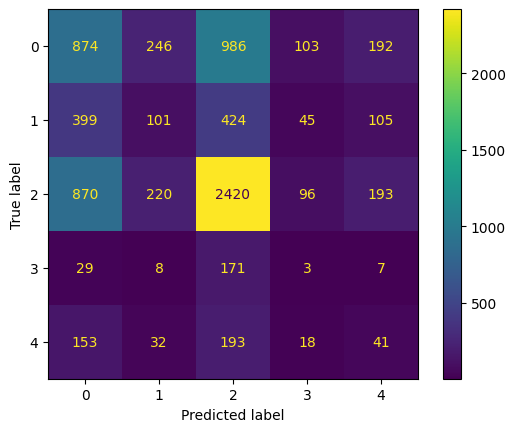

Accuracy: 0.43
Precision: 0.24
Recall: 0.24
F1: 0.24


In [72]:
classifier = MultiClassLogisticRegression(max_iter=10000, learning_rate=0.001)
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Logistic Regression",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

#### Multi-layered perceptron


In [ ]:
classifier = sk.neural_network.MLPClassifier()
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Neural Network",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

#### Classifier comparison


In [ ]:
compare_classifiers(scores)